In [10]:
import sys
path_to_quant = '//home/gridsan/djuna/homer/github/confocalQuant/'
sys.path.append(path_to_quant)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from aicsimageio import AICSImage

from confocalQuant.image import *

from confocalQuant.segmentation import get_czi_files, impose_segmentation
from confocalQuant.data_handling import return_results, load_im_from_memmap


def add_scale_bar(size, img, plt):
    end = np.round(size/img.physical_pixel_sizes[2])
    for i in range(3):
        plt[10:15,20:(20+int(end)),i] = 1
  
def get_meta_vectors(in_parent, files, spacer):
    meta = pd.read_csv(in_parent + 'temp.csv')
    meta.columns = ['file', 'line', 'treatment']
    meta['well'] = [x.split(spacer)[0] for x in meta['file']]

    dictionary = dict(zip(meta['well'], meta['line']))
    dictionary2 = dict(zip(meta['well'], meta['treatment']))

    lines = np.array([dictionary[x.split(spacer)[0]] for x in files])
    treat = np.array([dictionary2[x.split(spacer)[0]] for x in files])
    return lines, treat

In [2]:
df = pd.read_csv('../../scrap/outs/neuronbatch11082023_mitohealth_out//quant_continuous.csv')
out_parent = '../../scrap/outs/neuronbatch11082023_mitohealth_out//'
in_parent = '../../scrap/data/neuronbatch11082023_mitohealth/'
files = get_czi_files(in_parent)

lines, treat = get_meta_vectors(in_parent, files, '-')
all_mat, all_masks, Nzi_per_job, cells_per_job, zi_per_job, probs, randID_per_job = return_results(out_parent+'run_jobs_110823_mito.sbatch', '../../scrap/')

In [3]:
# get rep images
treatments = np.unique(df['treatment'])
dict_treat = dict(zip(df['file'], df['treatment']))
dict_line = dict(zip(df['file'], df['line']))

mean_per_filename, mean_per_condition = compute_avs(df, 'file', 'treatment', 'line', 'mitohealth')

In [4]:
vehicle = get_rep_im('vehicle', 'Y622', files, mean_per_condition, mean_per_filename, dict_treat, dict_line)
choline = get_rep_im('CDP-choline', 'Y622', files, mean_per_condition, mean_per_filename, dict_treat, dict_line)

rep = [choline, vehicle]

collabs = ['NeuN',  'mitohealth']
rowlabs = ['+CDP-choline', '+vehicle']

In [5]:
rep

[39, 36]

In [6]:
# determine upper dict
ma_out = []
mas_out = []

for i in rep:
    mask_sele, mat_sele = load_im_from_memmap(i, zi_per_job, Nzi_per_job, probs, all_masks, all_mat)
    ma_out.append(mat_sele)
    mas_out.append(mask_sele)
    
mat_sele = np.vstack(ma_out)
mask_sele = np.vstack(mas_out)
mat_sele = extract_channels([0,1,2,3], mat_sele)

nums = [88, 96, 94.5, 99.9] 
upper_dict = dict(zip(range(3), [np.percentile(mat_sele[:,:,:,x], nums[x]) for x in range(3)]))

nums = [88, 96, 99.5, 99.9] 
upper_dict2 = dict(zip(range(3), [np.percentile(mat_sele[:,:,:,x], nums[x]) for x in range(3)]))

lower_dict = {0: 0, 1: 0, 2: 0, 3: 0}
gamma_dict = {0: 1, 1: 1, 2: 1, 3:1}

nums = [0,93.9,0,95]
background_dict = dict(zip(range(3), [np.percentile(mat_sele[:,:,:,x], nums[x]) for x in range(3)]))

percentile=False

In [12]:
x1=[500,500]
x2=[700,700]
y1=[200,200]
y2=[400,400]

In [8]:
collabs = ['NeuN',  'mitohealth']

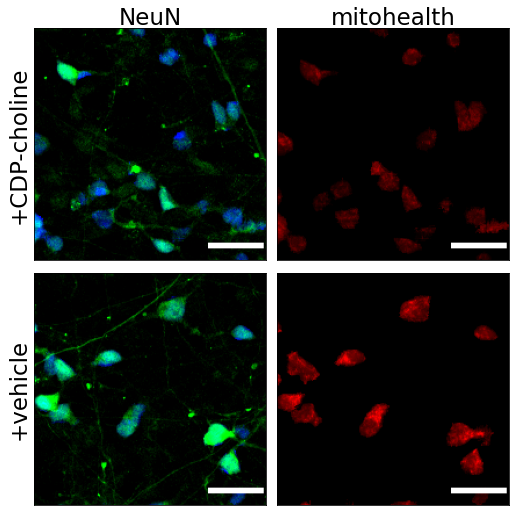

In [13]:
conditions = rep
fig, axes = plt.subplots(2, 2, figsize=(8.5, 8.8))#figsize=(27, 40))
fig.subplots_adjust(hspace=0.05, wspace=0.05)  # Adjust the spacing

for i in range(len(rep)):
    ID = conditions[i]
    mask_sele, mat_sele = load_im_from_memmap(ID, zi_per_job, Nzi_per_job, probs, all_masks, all_mat)
    mat_sele = extract_channels([0,1,2], mat_sele)

    plt1 = get_mean_projections(mat_sele, mask_sele,  background_dict={0:0, 1:93, 2:0 , 3:95}, gamma_dict=gamma_dict, lower_dict=lower_dict, upper_dict={0:99.9, 1:99, 2:99.2 , 3:99.9}, channels=[0,1], order=[2,1,0], mask_channel = [0], maskit=True, percentile=True)
    
    d = impose_segmentation(mask_sele, np.zeros_like(mat_sele), val=1)

    plt2 = get_mean_projections(mat_sele, mask_sele, background_dict=background_dict, gamma_dict=gamma_dict, lower_dict=lower_dict, upper_dict=upper_dict, channels=[2], order=[2,1,0], mask_channel = [2], maskit=True, percentile=percentile)

    # get image
    imgA = AICSImage(in_parent + files[ID])

    plot_axis(axes, plt1[y1[i]:y2[i],x1[i]:x2[i],:], i,0, 30, imgA, collabs, rowlabs)
    plot_axis(axes, plt2[y1[i]:y2[i],x1[i]:x2[i],:], i,1, 30, imgA, collabs, rowlabs)
    
#fig.savefig('../../out_ims/y622_mitohealth_final.png')
